---
title: "Data Cleaning"
format:
    html: 
        toc: true
        code-fold: false
        embedded-resouces: true
---

# U.S. Exoneration Data Cleaning

## Introduction and Motivation
This section documents the steps taken to clean and preprocess the U.S. exoneration dataset, with a specific focus on Illinois cases. The cleaning process transforms raw data into a usable format, ensuring accuracy and reliability for subsequent analysis. This iterative approach supports the investigation of systemic racial and judicial disparities in wrongful convictions.

By the end of this phase, the dataset will be structured, free of inconsistencies, and ready for exploratory data analysis (EDA) and machine learning workflows.

## Initial Overview of the Dataset

### Loading the Dataset

The dataset is first loaded to inspect its structure and contents. The purpose of this step is to get an initial sense of the data types, potential missing values, and the distribution of key variables. This helps inform the cleaning steps required to make the data consistent and analyzable.

In [341]:
# Import necessary Libraries
import pandas as pd 
import numpy as np 

# Load exoneration dataset
df = pd.read_csv('../../data/raw-data/US_exoneration_data.csv')
print("Initial Dataset: ")
pd.set_option('display.max_columns', None) # Enables display of every column
df.head()


Initial Dataset: 


,Last Name,First Name,Age,Race,Sex,State,County,Tags,Worst Crime Display,Sentence,Posting Date,OM Tags,F/MFE,FC,ILD,P/FA,DNA,MWID,OM,Date of Exoneration,Date of 1st Conviction,Date of Release
0,Abbitt,Joseph,31.0,Black,Male,North Carolina,Forsyth,CV;#IO;#SA,Child Sex Abuse,Life,9/1/11,NaN,NaN,NaN,NaN,NaN,DNA,MWID,NaN,9/2/09,6/22/95,9/2/09
1,Abbott,Cinque,19.0,Black,Male,Illinois,Cook,CIU;#IO;#NC;#P,Drug Possession or Sale,Probation,2/14/22,OF;#WH;#NW,NaN,NaN,NaN,P/FA,NaN,NaN,OM,2/1/22,3/25/08,3/25/08
2,Abdal,Warith Habib,43.0,Black,Male,New York,Erie,IO;#SA,Sexual Assault,20 to Life,8/29/11,OF;#WH;#NW;#WT,F/MFE,NaN,NaN,NaN,DNA,MWID,OM,9/1/99,6/6/83,9/1/99
3,Abernathy,Christopher,17.0,White,Male,Illinois,Cook,CIU;#CV;#H;#IO;#JV;#SA,Murder,Life without parole,2/13/15,OF;#WH;#NW;#INT,NaN,FC,NaN,P/FA,DNA,NaN,OM,2/11/15,1/15/87,2/11/15
4,Abney,Quentin,32.0,Black,Male,New York,New York,CV,Robbery,20 to Life,5/13/19,NaN,NaN,NaN,NaN,NaN,NaN,MWID,NaN,1/19/12,3/20/06,1/19/12


## Subsetting the Data: Illinois 

Before diving into the broader data cleaning process, I decided to narrow the scope of my research question to Illinois. This choice was intentional to focus the analysis on a specific region, ensuring that the findings are both relevant and manageable within the scope of this project. Illinois was selected because of its extensive record of exoneration cases, particularly in Cook County, which provides a valuable dataset for analyzing systemic issues within the criminal justice system. Chicago, in particular, has long been associated with significant racial disparities and deeply entrenched problems in policing and prosecution, making it a critical focal point for this analysis. By focusing on Illinois, the dataset remains consistent in terms of jurisdictional laws and practices, allowing for a more accurate and concentrated exploration of patterns and trends in over-policing and wrongful convictions. This regional focus highlights the broader systemic failures of the criminal justice system while enabling a detailed examination of one of the most historically inequitable jurisdictions in terms of racial justice.

### Filtering the Dataset
To isolate Illinois cases, the dataset was filtered by the state column, retaining only rows where the value matched "Illinois." This step reduced the dataset to 548 rows, making it more manageable for analysis and visualization. Below is a preview of the filtered dataset:


In [342]:
# Filter Data for Illinois 
df = df[df['State'] == 'Illinois']
print("Number of exonerees for Illinois subset: " , df.shape[0]) 
df.head()

Number of exonerees for Illinois subset:  548


,Last Name,First Name,Age,Race,Sex,State,County,Tags,Worst Crime Display,Sentence,Posting Date,OM Tags,F/MFE,FC,ILD,P/FA,DNA,MWID,OM,Date of Exoneration,Date of 1st Conviction,Date of Release
1,Abbott,Cinque,19.0,Black,Male,Illinois,Cook,CIU;#IO;#NC;#P,Drug Possession or Sale,Probation,2/14/22,OF;#WH;#NW,NaN,NaN,NaN,P/FA,NaN,NaN,OM,2/1/22,3/25/08,3/25/08
3,Abernathy,Christopher,17.0,White,Male,Illinois,Cook,CIU;#CV;#H;#IO;#JV;#SA,Murder,Life without parole,2/13/15,OF;#WH;#NW;#INT,NaN,FC,NaN,P/FA,DNA,NaN,OM,2/11/15,1/15/87,2/11/15
5,Abrego,Eruby,20.0,Hispanic,Male,Illinois,Cook,CDC;#H;#IO,Murder,90 years,8/25/22,OF;#WH;#NW;#WT;#INT;#PJ,NaN,FC,NaN,P/FA,NaN,MWID,OM,7/21/22,9/22/04,7/21/22
10,Adams,Demetris,22.0,Black,Male,Illinois,Cook,CIU;#IO;#NC;#P,Drug Possession or Sale,1 year,4/13/20,OF;#WH;#NW,NaN,NaN,NaN,P/FA,NaN,NaN,OM,2/11/20,9/8/04,12/26/04
15,Adams,Kenneth,22.0,Black,Male,Illinois,Cook,CDC;#H;#IO;#JI;#SA,Murder,75 years,8/29/11,PR;#OF;#WH;#NW;#KP;#WT,F/MFE,NaN,NaN,P/FA,DNA,MWID,OM,7/2/96,10/20/78,6/14/96


## Handling Missing Data

### Identifying Missing Data

Missing values are identified using `isnull()` to determine their extent and distribution across the dataset. The goal is to ensure that no critical data gaps remain unaddressed before proceeding with analysis.

In [343]:
# Managing Missing Data - Identifying which columns have a lot of missing data
na_counts = df.isna().sum()
print(na_counts)

Last Name                   0
First Name                  0
Age                         1
Race                        0
Sex                         0
State                       0
County                      0
Tags                       15
Worst Crime Display         0
Sentence                    0
Posting Date                0
OM Tags                    70
F/MFE                     474
FC                        410
ILD                       440
P/FA                       67
DNA                       482
MWID                      442
OM                         70
Date of Exoneration         0
Date of 1st Conviction      0
Date of Release             0
dtype: int64


### Handling Missing Data

#### Rationale for Dropping Columns

The following columns were removed due to excessive missing data or redundancy:
- **F/MFE, ILD, P/FA, DNA, MWID, FC**: Each of these columns had more than 50% missing values, which made them unreliable for meaningful analysis. Removing them ensures the dataset remains robust and manageable without introducing bias from imputation.

FIX!! While **OM Tags and OM** columns had a lot of missing values, I initiall removed them but during EDA realized I actually wanted to explore. 

In [344]:
# Drop columns with excessive missing values 
df_original = df.copy()
df.drop(columns = ['F/MFE', 'ILD', 'P/FA', 'DNA', 'MWID', 'FC'], inplace = True)

#### Visualizing Missing Data

To better understand the distribution of missing values, a heatmap is generated. This visualization provides a clear overview of where missing values occur, helping to decide which columns or rows to address in subsequent steps.

##### Heatmap of Missing Values (Before Cleaning)

A heatmap is generated to visualize the extent of missing data before cleaning. Columns with a high proportion of missing values are easily identifiable, providing a clear justification for their removal.


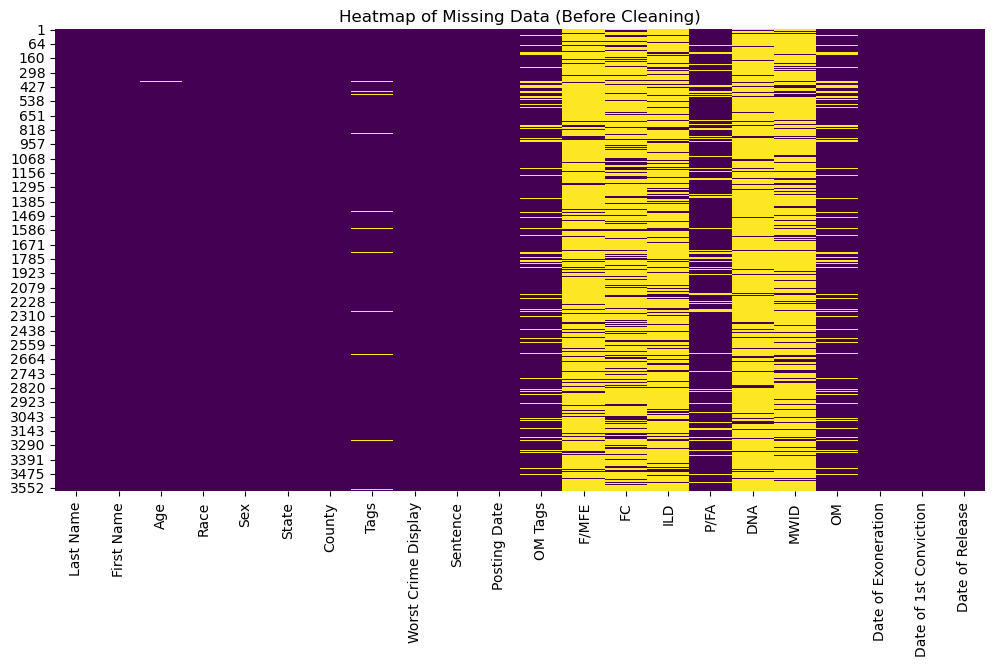

In [345]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap of missing data before cleaning
plt.figure(figsize=(12, 6))
sns.heatmap(df_original.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Data (Before Cleaning)')
plt.show()


##### Heatmap of Missing Values (After Cleaning)
A second heatmap is generated after cleaning to confirm that all unnecessary columns with excessive missing values have been removed. This ensures the dataset is now complete and ready for further analysis.


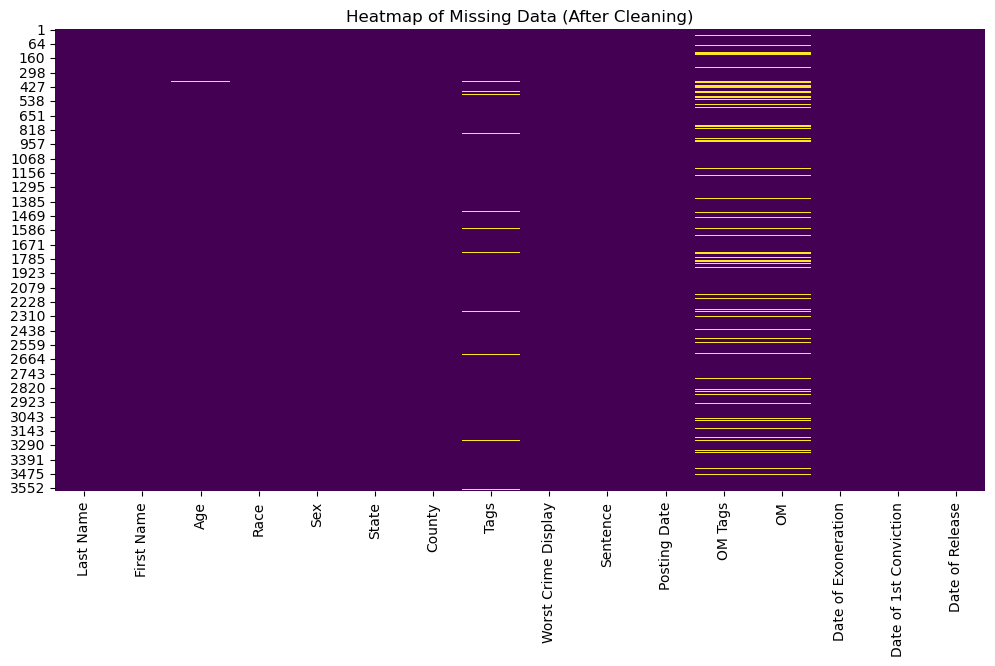

In [346]:
# Heatmap of missing data after cleaning
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Data (After Cleaning)')
plt.show()

### Summary of Missing Data Handling

Through this process, all missing data was evaluated and either addressed or removed. Columns with excessive missing values were dropped, while remaining data was retained to ensure completeness and reliability. The resulting dataset is now free of significant missing data, ready for further cleaning and analysis steps.

In [347]:
# Filter Data for Illinois 
df = df[df['State'] == 'Illinois']
print("Number of exonerees for Illinois subset: " , df.shape[0]) 
df.head()

Number of exonerees for Illinois subset:  548


,Last Name,First Name,Age,Race,Sex,State,County,Tags,Worst Crime Display,Sentence,Posting Date,OM Tags,OM,Date of Exoneration,Date of 1st Conviction,Date of Release
1,Abbott,Cinque,19.0,Black,Male,Illinois,Cook,CIU;#IO;#NC;#P,Drug Possession or Sale,Probation,2/14/22,OF;#WH;#NW,OM,2/1/22,3/25/08,3/25/08
3,Abernathy,Christopher,17.0,White,Male,Illinois,Cook,CIU;#CV;#H;#IO;#JV;#SA,Murder,Life without parole,2/13/15,OF;#WH;#NW;#INT,OM,2/11/15,1/15/87,2/11/15
5,Abrego,Eruby,20.0,Hispanic,Male,Illinois,Cook,CDC;#H;#IO,Murder,90 years,8/25/22,OF;#WH;#NW;#WT;#INT;#PJ,OM,7/21/22,9/22/04,7/21/22
10,Adams,Demetris,22.0,Black,Male,Illinois,Cook,CIU;#IO;#NC;#P,Drug Possession or Sale,1 year,4/13/20,OF;#WH;#NW,OM,2/11/20,9/8/04,12/26/04
15,Adams,Kenneth,22.0,Black,Male,Illinois,Cook,CDC;#H;#IO;#JI;#SA,Murder,75 years,8/29/11,PR;#OF;#WH;#NW;#KP;#WT,OM,7/2/96,10/20/78,6/14/96


## Column Standardization
To ensure consistency and simplify future operations, all column names were standardized by converting them to lowercase and replacing spaces with underscores (_). This transformation enhances readability, aligns with Python's naming conventions, and makes column names easier to reference in code. For example, a column originally labeled First Name is now first_name.

In [348]:
# Standardize column names by converting to lowercase and replacing spaces with '_'
df.columns = df.columns.str.lower().str.replace(' ', '_')
print(df.columns)

Index(['last_name', 'first_name', 'age', 'race', 'sex', 'state', 'county',
       'tags', 'worst_crime_display', 'sentence', 'posting_date', 'om_tags',
       'om', 'date_of_exoneration', 'date_of_1st_conviction',
       'date_of_release'],
      dtype='object')


### Text Value Standardization
Additionally, the sex column was converted to lowercase to maintain uniformity across textual data. This step ensures that values like "Male" and "male" are treated equivalently during analysis, reducing potential discrepancies caused by case sensitivity.

In [349]:
# Convert sex values to lowercase 
df['sex'] = df['sex'].str.lower()
df['sex'].head()

1     male
3     male
5     male
10    male
15    male
Name: sex, dtype: object

## Data Type Correction and Formatting
Accurate data type formatting is essential for effective analysis. This section ensures that all variables are correctly identified as numerical, categorical, or date-time types and that they are ready for further processing.

In [350]:
# Display data types for each column
print(df.dtypes)

last_name                  object
first_name                 object
age                       float64
race                       object
sex                        object
state                      object
county                     object
tags                       object
worst_crime_display        object
sentence                   object
posting_date               object
om_tags                    object
om                         object
date_of_exoneration        object
date_of_1st_conviction     object
date_of_release            object
dtype: object


### Data Type Correction for Textual Data
Upon reviewing the data types, it was noted that several columns, such as Last Name, First Name, Race, State, County, and Worst Crime Display, were classified as object. While this is acceptable for textual data, converting these columns to string ensures consistency and prevents potential issues when performing text-specific operations. This transformation also allows for better optimization and clarity in the data processing pipeline. The changes were necessary to standardize the dataset and ensure compatibility with downstream analysis tasks.

In [351]:
# Convert relevant columns to string type
string_columns = ['last_name', 'first_name', 'race', 'sex', 'state', 'county', 'worst_crime_display']
df[string_columns] = df[string_columns].astype('string')

# Check updated data types
print(df.dtypes)

last_name                 string[python]
first_name                string[python]
age                              float64
race                      string[python]
sex                       string[python]
state                     string[python]
county                    string[python]
tags                              object
worst_crime_display       string[python]
sentence                          object
posting_date                      object
om_tags                           object
om                                object
date_of_exoneration               object
date_of_1st_conviction            object
date_of_release                   object
dtype: object


### Date-Time Conversion
All date columns (`posting_date`, `date_of_exoneration`, `date_of_1st_conviction`, `date_of_release`) are converted to `datetime` format. This transformation ensures consistency and allows for easier time-based calculations, such as measuring the time between conviction and exoneration.


In [352]:
# Convert date columns into datetime format
for col in ['posting_date', 'date_of_exoneration', 'date_of_1st_conviction', 'date_of_release']:
    try:
        # Attempt to convert with explicit format (MM/DD/YY)
        df[col] = pd.to_datetime(df[col], format='%m/%d/%y', errors='coerce')
    except Exception as e:
        print(f"Error processing column {col}: {e}")
        df[col] = pd.to_datetime(df[col], errors='coerce')  # Fallback to auto-detection

print(df[['posting_date', 'date_of_exoneration', 'date_of_1st_conviction', 'date_of_release']].head())

   posting_date date_of_exoneration date_of_1st_conviction date_of_release
1    2022-02-14          2022-02-01             2008-03-25      2008-03-25
3    2015-02-13          2015-02-11             1987-01-15      2015-02-11
5    2022-08-25          2022-07-21             2004-09-22      2022-07-21
10   2020-04-13          2020-02-11             2004-09-08      2004-12-26
15   2011-08-29          1996-07-02             1978-10-20      1996-06-14


In [353]:
# Check updated data types
print(df.dtypes)

last_name                 string[python]
first_name                string[python]
age                              float64
race                      string[python]
sex                       string[python]
state                     string[python]
county                    string[python]
tags                              object
worst_crime_display       string[python]
sentence                          object
posting_date              datetime64[ns]
om_tags                           object
om                                object
date_of_exoneration       datetime64[ns]
date_of_1st_conviction    datetime64[ns]
date_of_release           datetime64[ns]
dtype: object


### Standardizing the `sentence` Column
The `sentence` column contains textual descriptions of sentencing outcomes, including terms like "Life without parole," "Death," or a specified number of years. To facilitate analysis, I transform this column into a numerical format (`sentence_in_years`) by converting life sentences and probation to placeholder values and handling ranges or mixed units (e.g., years and months).


In [354]:
# Print unique sentencing values for a better idea on how to best clean column 
unique_sentences = df['sentence'].unique()
print(unique_sentences)

['Probation' 'Life without parole' '90 years' '1 year' '75 years'
 '30 years' '55 years' '2 years' '3 years' '6 years' '45 years'
 '1 year and 6 months' '50 years' '60 years' 'Life' '80 years' '18 years'
 '4 years' '85 years' '20 years' '35 years' '2 years and 6 months'
 '82 years' '12 years' 'Not sentenced' '22 years' '32 years' 'Death'
 '5 years' '40 years' '25 years' '26 years' '4 years and 6 months'
 '9 years' '48 years' '30 days' '84 years' '3 months and 25 days'
 '2 years and 2 months' '3 months' '44 years' '6 months' '25 to 50 years'
 '29 years' '23 years' '31 years' '11 years' '8 years' '24 years'
 '3 years and four months' '42 years' '3 years and 6 months' '65 years'
 '76 years' '15 years' '50 to Life' '86 years' '70 years' '28 years'
 '13 years' '47 years' '36 years' '18 months' '1 year and 4 months'
 '8 years and 6 months' '6 years and 6 months' '58 years' '95 years'
 '7 years' '34 years' '62 years' '27 years' '69 years' '57 years'
 '50 to 100 years' '4 months' '4 years and 

##### Transforming the `sentence` Column
The `sentence` column is cleaned to convert textual descriptions into numerical values:
1. Probation and Not Sentenced are set to `0`.
2. Life sentences and the death penalty are represented as `100` for placeholder analysis.
3. Ranges (e.g., "25 to 50 years") are averaged to a single value.
4. Years and months are combined into total years for uniformity.

This standardization facilitates meaningful comparisons and quantitative analysis of sentencing patterns.


In [355]:
import re
def clean_sentence(value):
    """ Cleans the 'sentence' column values to numeric years for numerical EDA 
    - Probation is represented as 0.
    - 'Not sentenced' is converted to np.nan.
    - 'Life' and 'Death' sentences are represented as 100 (placeholder).
    - Years and months are converted to a numeric value in years. """

    if value == 'Probation':
        return 0
    elif value == 'Not sentenced':
        return np.nan  # NaN for not sentenced
    elif 'Life' in value or value == 'Death':
        return 100  # Placeholder for life sentences or death penalty
    elif 'year' in value or 'month' in value:

        # Handles ranges like '25 to 50 years'
        if 'to' in value:
            years = [int(num) for num in re.findall(r'\d+', value)]
            return sum(years) / len(years)  # Average the range 
        
        # Handle "X years and Y months"
        elif 'and' in value:
            numbers = [float(num) for num in re.findall(r'\d+', value)]
            if len(numbers) == 2:  # Both years and months are present
                years, months = numbers
                return years + (months / 12)  # Convert months to years
            elif len(numbers) == 1:  # Only one number is present
                return numbers[0]  # Treat it as years
            
        # Handle only months or only years
        elif 'months' in value:
            months = int(re.search(r'\d+', value).group())
            return months / 12  # Convert months to years
        else:  # Only years
            return int(re.search(r'\d+', value).group())
    else:
        return np.nan  # Anything unexpected as None
    
df['sentence_in_years'] = df['sentence'].apply(clean_sentence)

# Check results
df[['sentence', 'sentence_in_years']].head(10)

,sentence,sentence_in_years
1,Probation,0.0
3,Life without parole,100.0
5,90 years,90.0
10,1 year,1.0
15,75 years,75.0
21,Probation,0.0
22,Probation,0.0
24,30 years,30.0
25,55 years,55.0
45,1 year,1.0


In [356]:
# Check updated data types
print(df.dtypes)

last_name                 string[python]
first_name                string[python]
age                              float64
race                      string[python]
sex                       string[python]
state                     string[python]
county                    string[python]
tags                              object
worst_crime_display       string[python]
sentence                          object
posting_date              datetime64[ns]
om_tags                           object
om                                object
date_of_exoneration       datetime64[ns]
date_of_1st_conviction    datetime64[ns]
date_of_release           datetime64[ns]
sentence_in_years                float64
dtype: object


After transforming the sentence column into a numerical format, the new column, `sentence_in_years` is now represented as a float64, which aligns with the desired structure for numerical analysis. This conversion allows for quantitative exploration of the sentencing data, such as aggregations and comparisons, during later stages of analysis. The original sentence column is retained for reference purposes, as it preserves the detailed textual descriptions that might be useful for contextual insights. The tags column will be addressed later, so for now the datatype may remain as an object.

## Cleaning the `tags` Column !!UPDATE THIS
The `tags` column contains important categorical information about each exoneration case. To make this data more useful for analysis, I transformed the column into multiple binary columns, where each tag indicates the presence (`1`) or absence (`0`) of a specific feature. Additionally, I created a `tag_sum` column to capture the total number of tags associated with each case, providing a quick summary metric.

The cleaning process involved the following steps:

1. **Removing Unnecessary Characters**: Unwanted characters such as `#` were removed, and delimiters were standardized to ensure consistency in the data.

2. **Splitting Tags**: The `tags` column was split into individual values to facilitate binary encoding.

3. **Renaming Binary Columns**: Each binary column was renamed using clear and descriptive labels by mapping the original tags to their definitions. This mapping process translated short tag codes into their full meanings, improving interpretability. For reference, the definitions of the tags are based on the descriptions provided on the [National Registry of Exonerations: Exoneration Detail List](https://www.law.umich.edu/special/exoneration/Pages/detaillist.aspx){target=_blank} .

4. **Adding a `tag_sum` Column**: A new column was created to calculate the total number of tags for each case, enabling easier analysis of case complexity.

This transformation ensures the data is well-structured and ready for exploratory analysis, providing detailed insights into the systemic patterns in exoneration cases.


In [357]:
# Clean 'tags' column
df['tags'] = df['tags'].str.replace('#', '', regex=False).str.replace(";", ",")
df['OM-tags'] = df['om_tags'].str.replace('#', '', regex=False).str.replace(";", ",")

# Define the mapping for tags
tag_mapping = {
    "A": "arson",
    "BM": "bitemark",
    "CDC": "co_defendant_confessed",
    "CIU": "conviction_integrity_unit",
    "CSH": "child_sex_abuse_hysteria_case",
    "CV": "child_victim",
    "F": "female_exoneree",
    "FED": "federal_case",
    "H": "homicide",
    "IO": "innocence_organization",
    "JI": "jailhouse_informant",
    "JV": "juvenile_defendant",
    "M": "misdemeanor",
    "NC": "no_crime_case",
    "P": "guilty_plea_case",
    "PH": "posthumous_exoneration",
    "SA": "sexual_assault",
    "SBS": "shaken_baby_syndrome_case",
    "PR": "prosecutor_misconduct",
    "OF": "police_officer_misconduct",
    "FA": "forensic_analyst_misconduct",
    "CW": "child_welfare_worker_misconduct",
    "WH": "withheld_exculpatory_evidence",
    "NW": "misconduct_that_is_not_withholding_evidence",
    "KP": "knowingly_permitting_perjury",
    "WT": "witness_tampering_or_misconduct_interrogating_co_defendant",
    "INT": "misconduct_in_interrogation_of_exoneree",
    "PJ": "perjury_by_official",
    "PL": "prosecutor_lied_in_court"
}

# Split 'tags' and 'OM-tags' into lists
df['tags'] = df['tags'].apply(lambda x: x.split(',') if isinstance(x, str) else x)
df['OM-tags'] = df['OM-tags'].apply(lambda x: x.split(',') if isinstance(x, str) else x)

# Create binary columns for tags from both 'tags' and 'OM-tags'
for tag in tag_mapping.keys():
    # Check if the tag exists in 'tags' or 'OM-tags'
    df[tag] = df.apply(
        lambda row: 1 if (isinstance(row['tags'], list) and tag in row['tags']) or 
                          (isinstance(row['OM-tags'], list) and tag in row['OM-tags']) else 0,
        axis=1
    )

# Rename the binary columns using the tag_mapping dictionary
df.rename(columns=tag_mapping, inplace=True)

# Create `tag_sum` column to count the total number of tags for each exoneree
df['tag_sum'] = df[list(tag_mapping.values())].sum(axis=1)

# Drop the original 'tags' and 'OM-tags' columns
df.drop(columns=['tags', 'om_tags', 'OM-tags'], inplace=True)

df.head()  # Preview the updated DataFrame


,last_name,first_name,age,race,sex,state,county,worst_crime_display,sentence,posting_date,om,date_of_exoneration,date_of_1st_conviction,date_of_release,sentence_in_years,arson,bitemark,co_defendant_confessed,conviction_integrity_unit,child_sex_abuse_hysteria_case,child_victim,female_exoneree,federal_case,homicide,innocence_organization,jailhouse_informant,juvenile_defendant,misdemeanor,no_crime_case,guilty_plea_case,posthumous_exoneration,sexual_assault,shaken_baby_syndrome_case,prosecutor_misconduct,police_officer_misconduct,forensic_analyst_misconduct,child_welfare_worker_misconduct,withheld_exculpatory_evidence,misconduct_that_is_not_withholding_evidence,knowingly_permitting_perjury,witness_tampering_or_misconduct_interrogating_co_defendant,misconduct_in_interrogation_of_exoneree,perjury_by_official,prosecutor_lied_in_court,tag_sum
1,Abbott,Cinque,19.0,Black,male,Illinois,Cook,Drug Possession or Sale,Probation,2022-02-14,OM,2022-02-01,2008-03-25,2008-03-25,0.0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,7
3,Abernathy,Christopher,17.0,White,male,Illinois,Cook,Murder,Life without parole,2015-02-13,OM,2015-02-11,1987-01-15,2015-02-11,100.0,0,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,10
5,Abrego,Eruby,20.0,Hispanic,male,Illinois,Cook,Murder,90 years,2022-08-25,OM,2022-07-21,2004-09-22,2022-07-21,90.0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,1,1,0,9
10,Adams,Demetris,22.0,Black,male,Illinois,Cook,Drug Possession or Sale,1 year,2020-04-13,OM,2020-02-11,2004-09-08,2004-12-26,1.0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,7
15,Adams,Kenneth,22.0,Black,male,Illinois,Cook,Murder,75 years,2011-08-29,OM,1996-07-02,1978-10-20,1996-06-14,75.0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,1,1,0,0,1,1,1,1,0,0,0,11


In [358]:
# Convert 'OM' column to binary (1 if "OM" is present, 0 otherwise)
df['om'] = df['om'].apply(lambda x: 1 if str(x).strip().upper() == "OM" else 0)

# Verify the transformation
print(df['om'].value_counts())


om
1    478
0     70
Name: count, dtype: int64


## County Geocoding 

To enrich the dataset and enable more advanced geographic analysis, I incorporated geocoded data, including latitude, longitude, and full address (geocode). This addition allows for deeper exploratory data analysis (EDA) of geographic patterns within Illinois. By including location data, I can examine trends and disparities across counties, evaluate geographic clustering of exoneration cases, and explore how systemic factors vary by region. The geocoded data adds a crucial spatial dimension to the analysis, providing the foundation for mapping, visualizations, and further geographic exploration.

To perform the geocoding, I used **GeoPy**, a Python client for geocoding web services ([documentation here](https://geopy.readthedocs.io/en/stable/){target=_blank}). GeoPy provides an easy-to-use interface for accessing geocoding services, including the ability to retrieve latitude, longitude, and full address information from place names.

### Optimization of the Geocoding Process

To minimize redundant API calls and enhance efficiency, I focused on unique combinations of county and state. Instead of geocoding every record in the dataset (which would result in repeated calls for the same county, such as Cook County), I first extracted unique county-state pairs. These unique combinations were geocoded, capturing the address, latitude, and longitude for each pair. The results were then mapped back to the full dataset based on county and state.

This approach not only reduced the number of API calls, saving both time and resources, but also ensured consistency in the geocoded results. By geocoding only unique counties, I avoided unnecessary repetition and maintained a streamlined process while enriching the dataset with geographic context.


In [359]:
from geopy.geocoders import Nominatim

# Strip extra spaces and ensure consistent capitalization
df['county'] = df['county'].str.strip().str.title()
df['state'] = df['state'].str.strip().str.title()

# Initialize the geolocator
geolocator = Nominatim(user_agent="illinois_exoneration_geocode") 

# Get unique combinations of county and state - avoids repition and extra work for geocoder
unique_counties = df[['county', 'state']].drop_duplicates()

#  Define a function to geocode unique counties
def geocode_unique(row):
    try:
        #print(f"Geocoding: {row['county']} County, {row['state']}, USA") # Debugging
        location = geolocator.geocode(f"{row['county']} County, {row['state']}, USA")
        if location:
            #print(f"Success: {location.address}") #debugging
            return {
                'address': location.address,
                'latitude': location.latitude,
                'longitude': location.longitude
            }
        else:
            print(f"Failed: No result for {row['county']} County, {row['state']}")
            return None
    except Exception as e:
        print(f"Error geocoding {row['county']}, {row['state']}: {e}")
        return None

# Apply the geocoding function to unique counties
geocoded_results = unique_counties.apply(geocode_unique, axis=1)

# Split results into separate columns
unique_counties['geocode_address'] = geocoded_results.apply(lambda x: x['address'] if isinstance(x, dict) and 'address' in x else None)
unique_counties['latitude'] = geocoded_results.apply(lambda x: x['latitude'] if isinstance(x, dict) and 'latitude' in x else None)
unique_counties['longitude'] = geocoded_results.apply(lambda x: x['longitude'] if isinstance(x, dict) and 'longitude' in x else None)

# Merge the geocoded results back into the original dataset
df = df.merge(unique_counties, on=['county', 'state'], how='left')

print(df[['state', 'county', 'geocode_address', 'latitude', 'longitude']].head())


      state county                       geocode_address   latitude  longitude
0  Illinois   Cook  Cook County, Illinois, United States  41.819738 -87.756525
1  Illinois   Cook  Cook County, Illinois, United States  41.819738 -87.756525
2  Illinois   Cook  Cook County, Illinois, United States  41.819738 -87.756525
3  Illinois   Cook  Cook County, Illinois, United States  41.819738 -87.756525
4  Illinois   Cook  Cook County, Illinois, United States  41.819738 -87.756525


## Column Reorganization

To improve readability and logical flow, I move the `sentence_in_years` column to appear immediately after `sentence`. This makes it easier to analyze the cleaned numerical representation of the sentencing data alongside its original textual description.

In [360]:
# Reordering columns
columns = list(df.columns)  # Get all columns
columns.insert(columns.index('sentence') + 1, columns.pop(columns.index('sentence_in_years')))  # Move 'sentence_in_years'

# Move 'latitude' and 'longitude' after 'county'
columns.insert(columns.index('county') + 1, columns.pop(columns.index('latitude')))
columns.insert(columns.index('county') + 2, columns.pop(columns.index('longitude')))

df = df[columns]  # Reorder DataFrame

df.head(10)

,last_name,first_name,age,race,sex,state,county,latitude,longitude,worst_crime_display,sentence,sentence_in_years,posting_date,om,date_of_exoneration,date_of_1st_conviction,date_of_release,arson,bitemark,co_defendant_confessed,conviction_integrity_unit,child_sex_abuse_hysteria_case,child_victim,female_exoneree,federal_case,homicide,innocence_organization,jailhouse_informant,juvenile_defendant,misdemeanor,no_crime_case,guilty_plea_case,posthumous_exoneration,sexual_assault,shaken_baby_syndrome_case,prosecutor_misconduct,police_officer_misconduct,forensic_analyst_misconduct,child_welfare_worker_misconduct,withheld_exculpatory_evidence,misconduct_that_is_not_withholding_evidence,knowingly_permitting_perjury,witness_tampering_or_misconduct_interrogating_co_defendant,misconduct_in_interrogation_of_exoneree,perjury_by_official,prosecutor_lied_in_court,tag_sum,geocode_address
0,Abbott,Cinque,19.0,Black,male,Illinois,Cook,41.819738,-87.756525,Drug Possession or Sale,Probation,0.0,2022-02-14,1,2022-02-01,2008-03-25,2008-03-25,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,7,"Cook County, Illinois, United States"
1,Abernathy,Christopher,17.0,White,male,Illinois,Cook,41.819738,-87.756525,Murder,Life without parole,100.0,2015-02-13,1,2015-02-11,1987-01-15,2015-02-11,0,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,10,"Cook County, Illinois, United States"
2,Abrego,Eruby,20.0,Hispanic,male,Illinois,Cook,41.819738,-87.756525,Murder,90 years,90.0,2022-08-25,1,2022-07-21,2004-09-22,2022-07-21,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,1,1,0,9,"Cook County, Illinois, United States"
3,Adams,Demetris,22.0,Black,male,Illinois,Cook,41.819738,-87.756525,Drug Possession or Sale,1 year,1.0,2020-04-13,1,2020-02-11,2004-09-08,2004-12-26,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,7,"Cook County, Illinois, United States"
4,Adams,Kenneth,22.0,Black,male,Illinois,Cook,41.819738,-87.756525,Murder,75 years,75.0,2011-08-29,1,1996-07-02,1978-10-20,1996-06-14,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,1,1,0,0,1,1,1,1,0,0,0,11,"Cook County, Illinois, United States"
5,Adams,Seneca,20.0,Black,male,Illinois,Cook,41.819738,-87.756525,Assault,Probation,0.0,2014-12-08,1,2006-12-19,2006-05-18,2006-05-18,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,6,"Cook County, Illinois, United States"
6,Adams,Tari,18.0,Black,male,Illinois,Cook,41.819738,-87.756525,Assault,Probation,0.0,2014-12-08,1,2006-12-19,2006-05-18,2006-05-18,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,6,"Cook County, Illinois, United States"
7,Agnew,Gregory,28.0,Black,male,Illinois,Lake,42.332738,-87.993955,Robbery,30 years,30.0,2018-01-18,0,2001-11-07,1988-06-14,2001-11-07,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"Lake County, Illinois, United States"
8,Aguirre,Omar,28.0,Hispanic,male,Illinois,Cook,41.819738,-87.756525,Murder,55 years,55.0,2011-08-29,1,2003-02-18,1999-03-09,2002-12-18,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,7,"Cook County, Illinois, United States"
9,Ali,Chauncey,37.0,Black,male,Illinois,Cook,41.819738,-87.756525,Drug Possession or Sale,1 year,1.0,2020-04-13,1,2020-02-11,2007-01-17,2007-06-27,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,7,"Cook County, Illinois, United States"


## Exporting the Cleaned Dataset

The final cleaned dataset is saved as `illinois_exoneration_data.csv`. This ensures that all preprocessing steps are reproducible, and the dataset can be used consistently across various analysis stages.


In [361]:
df.to_csv('../../data/processed-data/illinois_exoneration_data.csv', index=False)

print("Data saved to 'illinois_exoneration_data.csv'")

Data saved to 'illinois_exoneration_data.csv'


## Summary and Next Steps
This data cleaning process ensures the Illinois exoneration dataset is free of inconsistencies and ready for analysis. The cleaned data will now be used to conduct EDA and investigate patterns of racial disparity and judicial misconduct in wrongful convictions.

# Illinois Arrest Data

In [362]:
# Load exoneration dataset
arrest_data = pd.read_csv('../../data/raw-data/illinois_arrest_explorer_data.csv')
print("Initial Dataset: ")
pd.set_option('display.max_columns', None) # Enables display of every column
arrest_data.head()

Initial Dataset: 


,Year,race,county_Adams,county_Alexander,county_Bond,county_Boone,county_Brown,county_Bureau,county_Calhoun,county_Carroll,county_Cass,county_Champaign,county_Christian,county_Clark,county_Clay,county_Clinton,county_Coles,county_Cook Chicago,county_Cook County Suburbs,county_Crawford,county_Cumberland,county_Dekalb,county_Dewitt,county_Douglas,county_Dupage,county_Edgar,county_Edwards,county_Effingham,county_Fayette,county_Ford,county_Franklin,county_Fulton,county_Gallatin,county_Greene,county_Grundy,county_Hamilton,county_Hancock,county_Hardin,county_Henderson,county_Henry,county_Iroquois,county_Jackson,county_Jasper,county_Jefferson,county_Jersey,county_Jo Daviess,county_Johnson,county_Kane,county_Kankakee,county_Kendall,county_Knox,county_Lake,county_Lasalle,county_Lawrence,county_Lee,county_Livingston,county_Logan,county_Macon,county_Macoupin,county_Madison,county_Marion,county_Marshall,county_Mason,county_Massac,county_Mcdonough,county_Mchenry,county_Mclean,county_Menard,county_Mercer,county_Monroe,county_Montgomery,county_Morgan,county_Moultrie,county_Non County Agencies,county_Ogle,county_Peoria,county_Perry,county_Piatt,county_Pike,county_Pope,county_Pulaski,county_Putnam,county_Randolph,county_Richland,county_Rock Island,county_Saline,county_Sangamon,county_Schuyler,county_Scott,county_Shelby,county_St. Clair,county_Stark,county_Stephenson,county_Tazewell,county_Union,county_Vermilion,county_Wabash,county_Warren,county_Washington,county_Wayne,county_White,county_Whiteside,county_Will,county_Williamson,county_Winnebago,county_Woodford
0,2001,African American,226,147,25,18,18,48,6,12,1,2059,16,6,1,22,130,86781,26301,6,1,342,11,18,2265,1,1,108,6,1,6,25,1,1,52,1,1,1,6,92,250,580,1,246,6,16,16,2804,1669,122,314,5712,184,6,86,180,71,1104,34,1567,146,6,1,91,105,213,905,1,6,20,38,287,6,1,57,3403,60,1,13,1,153,1,81,6,1215,104,2200,6,1,1,2462,1,355,168,17,876,6,46,25,6,16,128,3000,75,2509,42
1,2001,Asian,1,1,1,1,1,1,1,1,1,49,1,1,1,1,1,722,460,1,1,15,1,1,139,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,97,1,1,1,135,1,1,1,1,1,1,1,12,1,1,1,1,6,6,16,1,1,1,1,1,1,1,1,12,1,1,1,1,1,1,1,1,1,1,17,1,1,1,6,1,1,6,1,1,1,1,1,1,1,1,14,1,28,1
2,2001,Hispanic,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,2001,Native American,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,146,30,1,1,1,1,1,17,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,16,1,1,1,10,1,1,1,1,1,1,1,6,1,1,1,1,1,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,1
4,2001,White,939,52,209,674,107,509,139,298,88,2334,335,264,117,229,1635,37099,36690,470,164,1740,539,181,13019,301,41,986,382,217,724,926,19,57,1014,78,206,75,134,569,585,857,87,607,575,532,198,9634,1607,1465,1160,15136,2689,412,845,1146,586,1388,523,4359,571,263,274,455,1007,3879,2285,92,410,572,749,1053,149,1,1009,3120,430,211,368,45,248,151,460,323,3117,711,3635,274,22,486,1601,59,644,1804,327,1743,324,444,265,245,668,1304,4144,631,4253,462


In [363]:
#Rename columns by removing 'county_' prefix
arrest_data.columns = [col.replace('county_', '').capitalize() if col.startswith('county_') else col for col in arrest_data.columns]

#Rename "African American" to "Black" in the column names
arrest_data['race'] = arrest_data['race'].replace('African American', 'Black')

# Combine "Cook Chicago" and "Cook County Suburbs" into a single "Cook" column
arrest_data['Cook'] = arrest_data['Cook chicago'] + arrest_data['Cook county suburbs']

# Drop the old columns
arrest_data.drop(columns=['Cook chicago', 'Cook county suburbs'], inplace=True)

arrest_data.head()

,Year,race,Adams,Alexander,Bond,Boone,Brown,Bureau,Calhoun,Carroll,Cass,Champaign,Christian,Clark,Clay,Clinton,Coles,Crawford,Cumberland,Dekalb,Dewitt,Douglas,Dupage,Edgar,Edwards,Effingham,Fayette,Ford,Franklin,Fulton,Gallatin,Greene,Grundy,Hamilton,Hancock,Hardin,Henderson,Henry,Iroquois,Jackson,Jasper,Jefferson,Jersey,Jo daviess,Johnson,Kane,Kankakee,Kendall,Knox,Lake,Lasalle,Lawrence,Lee,Livingston,Logan,Macon,Macoupin,Madison,Marion,Marshall,Mason,Massac,Mcdonough,Mchenry,Mclean,Menard,Mercer,Monroe,Montgomery,Morgan,Moultrie,Non county agencies,Ogle,Peoria,Perry,Piatt,Pike,Pope,Pulaski,Putnam,Randolph,Richland,Rock island,Saline,Sangamon,Schuyler,Scott,Shelby,St. clair,Stark,Stephenson,Tazewell,Union,Vermilion,Wabash,Warren,Washington,Wayne,White,Whiteside,Will,Williamson,Winnebago,Woodford,Cook
0,2001,Black,226,147,25,18,18,48,6,12,1,2059,16,6,1,22,130,6,1,342,11,18,2265,1,1,108,6,1,6,25,1,1,52,1,1,1,6,92,250,580,1,246,6,16,16,2804,1669,122,314,5712,184,6,86,180,71,1104,34,1567,146,6,1,91,105,213,905,1,6,20,38,287,6,1,57,3403,60,1,13,1,153,1,81,6,1215,104,2200,6,1,1,2462,1,355,168,17,876,6,46,25,6,16,128,3000,75,2509,42,113082
1,2001,Asian,1,1,1,1,1,1,1,1,1,49,1,1,1,1,1,1,1,15,1,1,139,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,97,1,1,1,135,1,1,1,1,1,1,1,12,1,1,1,1,6,6,16,1,1,1,1,1,1,1,1,12,1,1,1,1,1,1,1,1,1,1,17,1,1,1,6,1,1,6,1,1,1,1,1,1,1,1,14,1,28,1,1182
2,2001,Hispanic,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2
3,2001,Native American,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,17,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,16,1,1,1,10,1,1,1,1,1,1,1,6,1,1,1,1,1,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,1,176
4,2001,White,939,52,209,674,107,509,139,298,88,2334,335,264,117,229,1635,470,164,1740,539,181,13019,301,41,986,382,217,724,926,19,57,1014,78,206,75,134,569,585,857,87,607,575,532,198,9634,1607,1465,1160,15136,2689,412,845,1146,586,1388,523,4359,571,263,274,455,1007,3879,2285,92,410,572,749,1053,149,1,1009,3120,430,211,368,45,248,151,460,323,3117,711,3635,274,22,486,1601,59,644,1804,327,1743,324,444,265,245,668,1304,4144,631,4253,462,73789


In [364]:
arrest_data.to_csv('../../data/processed-data/arrest_data_by_year.csv', index=False)

In [365]:
# Aggregate totals across years for each race
aggregated_data = arrest_data.groupby('race').sum(numeric_only=True)
aggregated_data = aggregated_data.drop(columns=['Year'])
aggregated_data = aggregated_data.reset_index()
# Preview the aggregated data
aggregated_data.head()



,race,Adams,Alexander,Bond,Boone,Brown,Bureau,Calhoun,Carroll,Cass,Champaign,Christian,Clark,Clay,Clinton,Coles,Crawford,Cumberland,Dekalb,Dewitt,Douglas,Dupage,Edgar,Edwards,Effingham,Fayette,Ford,Franklin,Fulton,Gallatin,Greene,Grundy,Hamilton,Hancock,Hardin,Henderson,Henry,Iroquois,Jackson,Jasper,Jefferson,Jersey,Jo daviess,Johnson,Kane,Kankakee,Kendall,Knox,Lake,Lasalle,Lawrence,Lee,Livingston,Logan,Macon,Macoupin,Madison,Marion,Marshall,Mason,Massac,Mcdonough,Mchenry,Mclean,Menard,Mercer,Monroe,Montgomery,Morgan,Moultrie,Non county agencies,Ogle,Peoria,Perry,Piatt,Pike,Pope,Pulaski,Putnam,Randolph,Richland,Rock island,Saline,Sangamon,Schuyler,Scott,Shelby,St. clair,Stark,Stephenson,Tazewell,Union,Vermilion,Wabash,Warren,Washington,Wayne,White,Whiteside,Will,Williamson,Winnebago,Woodford,Cook
0,Asian,31,21,21,40,21,21,21,21,21,1186,21,21,21,26,21,21,21,301,21,21,4509,26,21,65,26,21,32,21,21,21,31,21,21,21,21,31,21,170,21,31,21,21,21,2239,46,76,21,2562,166,21,21,90,36,86,21,550,21,21,21,60,76,498,564,21,21,21,36,31,21,21,26,381,26,21,21,21,31,21,21,21,251,21,500,21,21,21,382,21,31,132,21,21,21,58,21,21,21,46,1443,51,767,60,26764
1,Black,4022,2722,533,2410,105,780,36,292,239,45547,459,190,85,877,4029,282,121,16146,594,500,59262,127,26,3293,591,278,520,627,26,118,2249,21,132,21,210,2131,3283,13120,61,5960,526,943,281,59806,27437,4308,7545,78841,7344,337,1654,4521,2353,27094,818,51485,4542,128,222,1731,4214,6581,27867,191,268,885,1275,7157,168,694,1685,79960,1901,359,519,36,3384,56,1731,213,26048,1796,63703,91,21,116,60744,41,11866,8363,399,17641,156,1024,489,99,464,2893,58968,4809,55837,2841,1772659
2,Hispanic,26,21,26,530,21,130,21,50,82,998,21,26,21,106,135,36,36,1796,98,161,13841,21,21,68,54,83,40,21,21,46,484,21,26,21,31,37,118,200,21,174,41,115,21,14164,648,278,337,10232,775,21,150,431,64,130,21,347,43,31,30,21,152,4139,1452,21,21,35,31,138,21,21,364,21,58,21,36,21,119,21,93,36,1149,21,46,31,21,21,461,21,55,207,36,21,21,157,31,21,26,450,3835,231,3535,80,144574
3,Native American,21,21,21,21,21,21,21,21,21,302,21,21,21,21,21,21,21,46,21,21,703,21,21,21,21,21,21,26,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,154,21,31,21,220,26,21,21,21,21,26,21,76,21,21,21,21,21,36,41,21,21,21,21,21,21,21,21,56,21,21,21,21,21,21,21,21,21,21,46,21,21,26,56,21,26,26,21,21,21,21,21,21,21,21,113,21,152,21,2351
4,White,16743,1340,3964,16580,1812,9593,1844,5530,2826,41996,10983,6714,4818,8858,23779,8663,4228,35622,7121,5676,215397,7031,1019,23978,9115,4630,22754,14545,838,5147,18813,1218,5203,1766,2653,11472,11041,16698,3124,14526,14337,7841,3325,170618,31714,27222,20553,188224,54179,8499,13856,20172,14366,30283,12071,130786,19686,4240,6970,8491,18618,101548,48554,3974,7257,10734,16631,23129,2920,752,19240,64589,12123,4323,7890,795,4457,1683,12061,6823,53728,12729,82714,2136,585,8671,49390,1442,13615,61546,6165,30772,6491,7459,5220,5146,11318,22690,97863,26871,85292,12676,1174775


In [366]:
aggregated_data.to_csv('../../data/processed-data/aggregated_arrests_2001_to_2021.csv', index=False)